# Using a New Machine Learning Classifier for Algorithmic Trading

Training a logistic regression model to make trading predictions, backtest the results, and then evaluate its performance compared to that of a SVM model.

In [1]:
# Imports
import pandas as pd
from pathlib import Path

### Read the CSV file into Pandas DataFrame

In [2]:
# Import the OHLCV dataset into a Pandas Dataframe
trading_df = pd.read_csv(
    Path("../Resources/ohlcv.csv"), 
    index_col="date", 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
trading_df.head()

,open,high,low,close,volume
date,,,,,
2018-10-19 09:30:00,16.90,17.18,16.90,17.095,11522
2018-10-19 09:45:00,17.11,17.44,17.11,17.400,70593
2018-10-19 10:00:00,17.40,17.40,17.25,17.280,38885
2018-10-19 10:15:00,17.27,17.27,17.18,17.200,37046
2018-10-19 10:30:00,17.21,17.37,17.19,17.200,46874


### Add a daily return values column to the DataFrame

In [3]:
# Calculate the daily returns using the closing prices and the pct_change function
trading_df["actual_returns"] = trading_df["close"].pct_change()

# Drop all NaN values from the DataFrame
trading_df = trading_df.dropna()

# Review the DataFrame
display(trading_df.head())
display(trading_df.tail())

,open,high,low,close,volume,actual_returns
date,,,,,,
2018-10-19 09:45:00,17.11,17.44,17.11,17.40,70593,0.017841
2018-10-19 10:00:00,17.40,17.40,17.25,17.28,38885,-0.006897
2018-10-19 10:15:00,17.27,17.27,17.18,17.20,37046,-0.004630
2018-10-19 10:30:00,17.21,17.37,17.19,17.20,46874,0.000000
2018-10-19 10:45:00,17.20,17.20,17.10,17.12,11266,-0.004651


,open,high,low,close,volume,actual_returns
date,,,,,,
2020-09-04 14:45:00,6.225,6.26,6.220,6.250,55512,0.003210
2020-09-04 15:00:00,6.255,6.27,6.245,6.250,65810,0.000000
2020-09-04 15:15:00,6.250,6.29,6.250,6.275,202630,0.004000
2020-09-04 15:30:00,6.270,6.28,6.250,6.255,130140,-0.003187
2020-09-04 15:45:00,6.250,6.28,6.250,6.250,190278,-0.000799


---

### Generating the Features and Target Sets

In [8]:
# Define a window size of 4 and 100
short_window = 4
long_window = 100

# Create a simple moving average (SMA) using the long_window and assign this to a new columns called sma_slow
trading_df["sma_slow"] = trading_df["close"].rolling(window=long_window).mean()
trading_df["sma_fast"] = trading_df["close"].rolling(window=short_window).mean()

In [9]:
# Drop the NaNs using dropna()
trading_df = trading_df.dropna()

#### Create the features set

In [10]:
# Assign a copy of the sma_fast and sma_slow columns to a new DataFrame called X
X = trading_df[["sma_fast", "sma_slow"]].copy()

# Display sample data
display(X.head())
display(X.tail())

,sma_fast,sma_slow
date,,
2018-10-30 13:45:00,14.78625,15.29820
2018-10-30 14:00:00,14.76875,15.28935
2018-10-30 14:15:00,14.76875,15.28185
2018-10-30 14:30:00,14.77250,15.27565
2018-10-30 14:45:00,14.77250,15.27005


,sma_fast,sma_slow
date,,
2020-09-04 14:45:00,6.22875,6.27030
2020-09-04 15:00:00,6.23875,6.26985
2020-09-04 15:15:00,6.25125,6.26910
2020-09-04 15:30:00,6.25750,6.26855
2020-09-04 15:45:00,6.25750,6.26785


#### Create the target set

In [11]:
# Create a new column in the trading_df called signal setting its value to zero.
trading_df["signal"] = 0.0

# Create the signal to buy
trading_df.loc[(trading_df["actual_returns"] >= 0), "signal"] = 1

# Create the signal to sell
trading_df.loc[(trading_df["actual_returns"] < 0), "signal"] = -1

In [12]:
# Copy the new signal column to a new Series called y.
y = trading_df["signal"].copy()

---

### Split the Data Into Training and Testing Datasets

#### Creating the Training Datasets

In [13]:
# Imports 
from pandas.tseries.offsets import DateOffset

In [14]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2018-10-30 13:45:00


In [15]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2019-01-30 13:45:00


In [16]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
X_train.head()

,sma_fast,sma_slow
date,,
2018-10-30 13:45:00,14.78625,15.29820
2018-10-30 14:00:00,14.76875,15.28935
2018-10-30 14:15:00,14.76875,15.28185
2018-10-30 14:30:00,14.77250,15.27565
2018-10-30 14:45:00,14.77250,15.27005


#### Creating the Testing Datasets

In [17]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
X_test.head()

,sma_fast,sma_slow
date,,
2019-01-30 13:45:00,14.57875,14.30576
2019-01-30 14:00:00,14.57125,14.31006
2019-01-30 14:15:00,14.58500,14.31471
2019-01-30 14:30:00,14.61750,14.32026
2019-01-30 14:45:00,14.63375,14.32411


#### Standardizing the Data

In [18]:
# Imports
from sklearn.preprocessing import StandardScaler

In [19]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

---

### Incorporate the SVM Machine Learning Into the Trading Strategy

In [20]:
# Imports
from sklearn import svm
from sklearn.metrics import classification_report

In [21]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [22]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.54      0.19      0.28       733
         1.0       0.53      0.85      0.65       785

    accuracy                           0.53      1518
   macro avg       0.53      0.52      0.46      1518
weighted avg       0.53      0.53      0.47      1518



---

### Backtesting a Machine Learning Trading Algorithm

In [23]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [24]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.47      0.38      0.42      4849
         1.0       0.53      0.62      0.57      5504

    accuracy                           0.51     10353
   macro avg       0.50      0.50      0.50     10353
weighted avg       0.50      0.51      0.50     10353



In [25]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df["predicted_signal"] = testing_signal_predictions
predictions_df["actual_returns"] = trading_df["actual_returns"]
predictions_df["trading_algorithm_returns"] = predictions_df["actual_returns"] * predictions_df["predicted_signal"]
predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
date,,,
2019-01-30 13:45:00,1.0,0.002408,0.002408
2019-01-30 14:00:00,1.0,0.002745,0.002745
2019-01-30 14:15:00,1.0,0.001027,0.001027
2019-01-30 14:30:00,1.0,0.002735,0.002735
2019-01-30 14:45:00,1.0,-0.002046,-0.002046


<Axes: xlabel='date'>

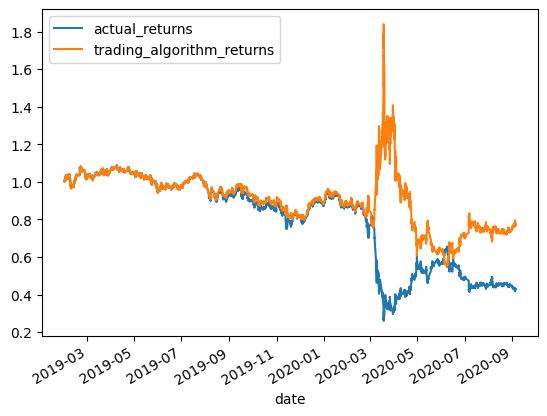

In [26]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

---

# Add a New Machine Learning Model

## Import the `LogisticRegression` model from scikit-learn.


In [27]:
# Import LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

In [28]:
# Create an instance of the LogisticRegression model
logistic_regression_model = LogisticRegression()


## Using the same training data that the SVM model used (`X_train_scaled` and `y_train`), fit the `LogisticRegression` model.

In [29]:
# Fit the LogisticRegression model

logistic_regression_model.fit(X_train_scaled, y_train)

LogisticRegression()

## Use the trained model to predict the trading signals for the training data. Use the `classification_report` module to evaluate the model.

In [30]:
# Use the trained LogisticRegression model to predict the trading signals for the training data
lr_training_signal_predictions = logistic_regression_model.predict(X_train_scaled)

# Display the predictions

lr_training_signal_predictions

array([-1., -1., -1., ...,  1.,  1.,  1.])

In [32]:
# Generate a classification report using the training data and the logistic regression model's predications
lr_training_report = classification_report(y_train, lr_training_signal_predictions)

# Review the classification report
print(lr_training_report)


              precision    recall  f1-score   support

        -1.0       0.52      0.15      0.23       733
         1.0       0.52      0.87      0.65       785

    accuracy                           0.52      1518
   macro avg       0.52      0.51      0.44      1518
weighted avg       0.52      0.52      0.45      1518



## Backtest the `LogisticRegression` model using the testing data to evaluate its performance.

In [33]:
# Use the trained model to predict the trading signals for the testing data.
lr_testing_signal_predictions = logistic_regression_model.predict(X_test_scaled)

In [34]:
# Generate a classification report using the testing data and the logistic regression model's predications
lr_testing_report = classification_report(y_test, lr_testing_signal_predictions)

# Review the classification report
print(lr_testing_report)


              precision    recall  f1-score   support

        -1.0       0.53      0.07      0.12      4849
         1.0       0.54      0.95      0.68      5504

    accuracy                           0.53     10353
   macro avg       0.53      0.51      0.40     10353
weighted avg       0.53      0.53      0.42     10353



## Compare the performance of the logistic regression and SVM models using the classification reports generated with the testing data. 

In [35]:
# Print the classification report for the SVM model using the test data
print("Logistic Regression Classification Report")
print(lr_testing_report)


Logistic Regression Classification Report
              precision    recall  f1-score   support

        -1.0       0.53      0.07      0.12      4849
         1.0       0.54      0.95      0.68      5504

    accuracy                           0.53     10353
   macro avg       0.53      0.51      0.40     10353
weighted avg       0.53      0.53      0.42     10353



In [36]:
# Print the classification report for the SVM model using the test data
print("SVM Classification Report")
print(svm_testing_report)


SVM Classification Report
              precision    recall  f1-score   support

        -1.0       0.47      0.38      0.42      4849
         1.0       0.53      0.62      0.57      5504

    accuracy                           0.51     10353
   macro avg       0.50      0.50      0.50     10353
weighted avg       0.50      0.51      0.50     10353

